In [1]:
using MPSExperiments
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, Graphs
using Plots, Statistics

In [2]:
include("../../../telegram/notifications.jl");

In [3]:
nA = 10^4
nB = nA
kA = 3
kB = kA

β = 1.0
JA = 0.75
JB = 0.45
h = 0.0;

In [4]:
n = nA + nB
include("random_bipartite_regular.jl")
A = random_bipartite_regular(nA, nB, kA, kB)
gg = BipartiteIndexedGraph(A)
g = IndexedBiDiGraph(adjacency_matrix(gg));

## Montecarlo


In [15]:
T = 300
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ nA ? JA : JB, h, β), T+1)
end
m⁰ = 0.5
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], n)

bp = mpbp(g, w, fill(2, n), T; ϕ)
sms = SoftMarginSampler(bp);

In [16]:
sample!(sms, 1*10^2);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:06:02


In [17]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m_mc = [[mss.val for mss in ms] for ms in means(spin, sms)];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:19


In [18]:
mean(m_mc[nA+1:end])[end], mean(m_mc[1:nA])[end], mean(m_mc)[end]

(0.3655440000000002, 0.3989580000000002, 0.38225100000000023)

In [19]:
uA, uB = 2.0, 2.0
bpu(u, J, k=3) = atanh(tanh(J)*tanh((k-1)*u))
f_bp(u1, u2) = bpu(u2, JB), bpu(u1, JA)
m_(u, k=3) = tanh(k*u)
for _ in 1:201
    uA, uB = f_bp(uA, uB)
end
m_(uA), m_(uB), 0.5 * (m_(uA) + m_(uB))

(0.46719889433700945, 0.5574026845295157, 0.5123007894332625)

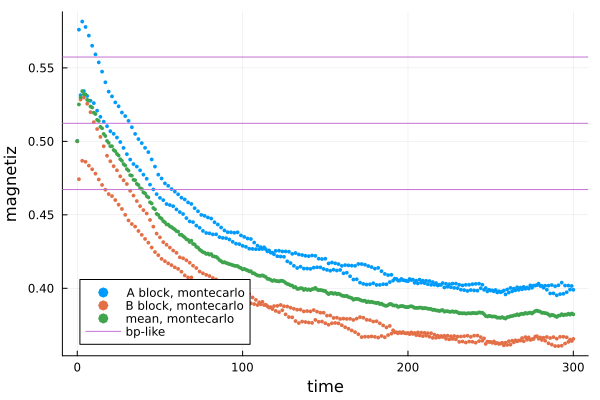

In [20]:
pl_mc = plot(; xlabel="time", ylabel="magnetiz")
markersize = 2
scatter!(0:T, mean(m_mc[1:nA]), label="A block, montecarlo"; m=:o, markersize, msc=:auto)
scatter!(0:T, mean(m_mc[nA+1:end]), label="B block, montecarlo"; m=:o, markersize, msc=:auto)
scatter!(0:T, mean(m_mc), label="mean, montecarlo"; m=:o, markersize, msc=:auto)
hline!([m_(uA), m_(uB), 0.5 * (m_(uA) + m_(uB))], label="bp-like")

## MPBP

In [36]:
w = [
    fill(HomogeneousGlauberFactor(JA, h, β), T+1),
    fill(HomogeneousGlauberFactor(JB, h, β), T+1)
]
ϕ = fill([t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], 2)
bp = mpbp_infinite_bipartite_graph((kA,kB), w, (2, 2), ϕ);

In [ ]:
cb = CB_BP(bp)
iterate!(bp; maxiter=20, svd_trunc=TruncBond(30), cb, tol=1e-5);

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [ ]:
m_bp = means(spin, bp)

pl_bp = deepcopy(pl_mc)
plot!(pl_bp, 0:T, m_bp[1], c=theme_palette(:auto)[1],
    label="A block, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, 0:T, m_bp[2], c=theme_palette(:auto)[2],
    label="B block, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, 0:T, (m_bp[1]*kB + m_bp[2]*kA) / (kA+kB), c=theme_palette(:auto)[3], 
    label="mean, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, legend=:bottomright)

In [ ]:
@telegram "glauber asymmetric bipartite"

## BP + VUMPS

In [21]:
fA = HomogeneousGlauberFactor(JA, h)
fB = HomogeneousGlauberFactor(JB, h);

In [28]:
d = 4

A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
B0 = copy(A0)
A0 = copy(A)
B0 = copy(B)

A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
    fA, fB, d; A0, B0
);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Running BP + VUMPS 100%|█████████████████████████████████| Time: 0:08:23
  ε:  0.027853387189155532/1.0e-10


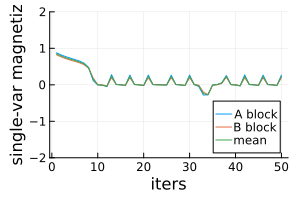

In [29]:
mA = [reduce(-, b) for b in beliefsA]
mB = [reduce(-, b) for b in beliefsB]
m = [reduce(-, b) for b in beliefs]

pl = plot()
plot!(mA, ylabel="single-var magnetiz", label="A block")
plot!(mB, ylabel="single-var magnetiz", label="B block")
plot!(m, ylabel="single-var magnetiz", label="mean")
plot!(ylims=(-2,2), legend=:bottomright, xlabel="iters", size=(300,200))

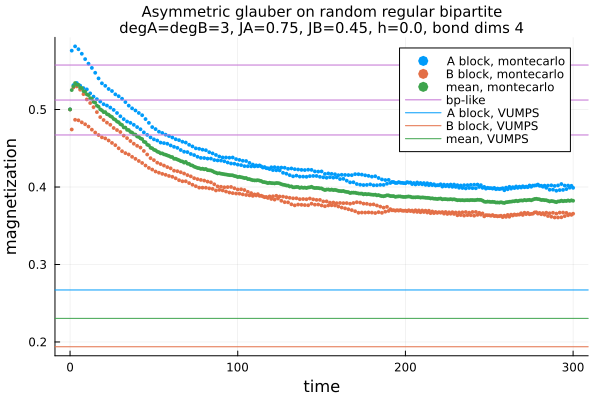

In [30]:
mAstat = mA[findlast(!isnan, mA)]
mBstat = mB[findlast(!isnan, mB)]
mstat = m[findlast(!isnan, m)]

pl2 = deepcopy(pl_mc)
plot!(pl2, title="Asymmetric glauber on random regular bipartite\ndegA=degB=3, JA=$JA, JB=$JB, h=$h, bond dims $d",
    titlefontsize=10, xlabel="time", ylabel="magnetization")
hline!(pl2, [mAstat], c=theme_palette(:auto)[1], label="A block, VUMPS")
hline!(pl2, [mBstat], c=theme_palette(:auto)[2], label="B block, VUMPS")
hline!(pl2, [mstat], c=theme_palette(:auto)[3], label="mean, VUMPS")

## Larger bond dimension

In [67]:
fA = HomogeneousGlauberFactor(JA, h)
fB = HomogeneousGlauberFactor(JB, h);

In [ ]:
d = 25

A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
B0 = copy(A0)
# A0 = copy(A)
# B0 = copy(B)

A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
    fA, fB, d; A0, B0
);

[ Info: VOMPS init:	err = 1.9227e-01
[ Info: VOMPS   1:	err = 2.4130336576e-01	time = 0.00 sec
[ Info: VOMPS   2:	err = 9.3295860356e-04	time = 0.07 sec
[ Info: VOMPS   3:	err = 6.3870398185e-08	time = 0.09 sec
[ Info: VOMPS conv 4:	err = 7.7230629119e-16	time = 0.18 sec


In [ ]:
mA = [reduce(-, b) for b in beliefsA]
mB = [reduce(-, b) for b in beliefsB]
m = [reduce(-, b) for b in beliefs]

pl = plot()
plot!(mA, ylabel="single-var magnetiz", label="A block")
plot!(mB, ylabel="single-var magnetiz", label="B block")
plot!(m, ylabel="single-var magnetiz", label="mean")
plot!(ylims=(-2,2), legend=:bottomright, xlabel="iters", size=(300,200))

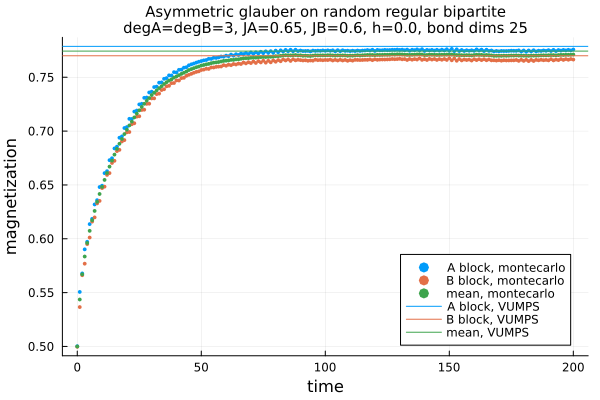

In [92]:
mAstat = mA[findlast(!isnan, mA)]
mBstat = mB[findlast(!isnan, mB)]
mstat = m[findlast(!isnan, m)]

pl2 = deepcopy(pl_mc)
plot!(pl2, title="Asymmetric glauber on random regular bipartite\ndegA=degB=3, JA=$JA, JB=$JB, h=$h, bond dims $d",
    titlefontsize=10, xlabel="time", ylabel="magnetization")
hline!(pl2, [mAstat], c=theme_palette(:auto)[1], label="A block, VUMPS")
hline!(pl2, [mBstat], c=theme_palette(:auto)[2], label="B block, VUMPS")
hline!(pl2, [mstat], c=theme_palette(:auto)[3], label="mean, VUMPS")

In [86]:
@telegram "glauber asymmetric bipartite"

## Comparison

In [24]:
JA = 0.65
JBs = 0.35:0.05:0.75
# JBs = 0.7:0.1:0.8
h = 0.0;

In [25]:
using Unzip

In [ ]:
msA, msB, ms = map(JBs) do JB
    w = map(vertices(g)) do i
        fill(HomogeneousGlauberFactor(i ≤ nA ? JA : JB, h, β), T+1)
    end
    m⁰ = 0.5
    ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], n)

    bp = mpbp(g, w, fill(2, n), T; ϕ)
    sms = SoftMarginSampler(bp)
    sample!(sms, 5*10^2)
    spin(x, i) = 3-2x
    spin(x) = spin(x, 0)
    m_mc = [[mss.val for mss in ms] for ms in means(spin, sms)]
    mA = mean(m_mc[1:nA])
    mB = mean(m_mc[nA+1:end])
    m = mean(m_mc)
    mA, mB, m
end |> unzip;

SoftMargin sampling   9%|██▉                             |  ETA: 0:03:33

In [ ]:
ms_bpA, ms_bpB, ms_bp = map(JBs) do JB
    uA, uB = 2.0, 2.0
    bpu(u, J, k=3) = atanh(tanh(J)*tanh((k-1)*u))
    f_bp(u1, u2) = bpu(u2, JB), bpu(u1, JA)
    m(u, k=3) = tanh(k*u)
    for _ in 1:201
        uA, uB = f_bp(uA, uB)
    end
    m(uA), m(uB), 0.5 * (m(uA) + m(uB))
end |> unzip

In [ ]:
ms_vumpsA, ms_vumpsB, ms_vumps = map(JBs) do JB
    fA = HomogeneousGlauberFactor(JA, h)
    fB = HomogeneousGlauberFactor(JB, h)
    d = 10

    A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
    B0 = copy(A0)

    A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
        fA, fB, d; A0, B0, maxiter=100, tol=1e-12
    )

    mA = [reduce(-, b) for b in beliefsA]
    mB = [reduce(-, b) for b in beliefsB]
    m = [reduce(-, b) for b in beliefs]

    mAstat = mA[findlast(!isnan, mA)]
    mBstat = mB[findlast(!isnan, mB)]   
    mstat = m[findlast(!isnan, m)]

    mAstat, mBstat, mstat
end |> unzip;

In [54]:
plot(JBs, [m[end] for m in ms], label="montecarlo", ms=3, msc=:auto, m=:o, ylabel="magnetiz")
plot!(JBs, ms_bp, label="meanfield", xlabel="JB", ms=3, msc=:auto, m=:o)
plot!(JBs, ms_vumps, label="vumps + BP", xlabel="JB", ms=3, msc=:auto, m=:o)
vline!([JA], ls=:dash, label="JA", size=(800,500))

LoadError: UndefVarError: `ms` not defined